# Rhythm Pattern Generator 

You need to run the Max patch in `playback_maxmsp` directory

In [1]:
# CONSTANTS

DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]

resolution  = 4 # divide quater note into 4  = 16 notes

nb_bars = 2  # number of bars 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note

n_z = 100

# MIDI Data
GENRES = ['Old Skool', 'DnB', 'Jungle', 'House', 'Breakbeat', 'Garage', 'Techno']
NB_GENRES = len(GENRES)

In [2]:
import tensorflow as tf

# store tensorflow graph object here for multi threading
graph = tf.get_default_graph()

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()        

In [4]:
import numpy as np
from keras.models import load_model

# Load CAN Model
generator = load_model("./tmp/can_generator.h5")

# Alternatively you can try Genre-Conditioned model
#generator = load_model("./tmp/c_generator-epoch-004-0.88661.h5")

Using TensorFlow backend.
W0725 12:09:16.111918 4441208256 deprecation_wrapper.py:119] From /Users/nao/anaconda3/envs/default/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 12:09:16.118521 4441208256 deprecation_wrapper.py:119] From /Users/nao/anaconda3/envs/default/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 12:09:16.120858 4441208256 deprecation_wrapper.py:119] From /Users/nao/anaconda3/envs/default/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 12:09:16.300251 4441208256 deprecation_wrapper.py:119] From /Users/nao/anaconda3/envs/default/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_defaul

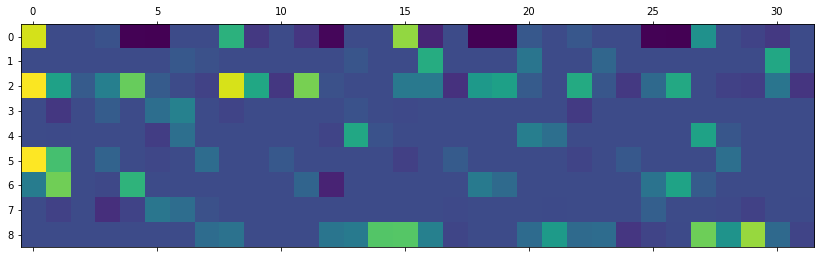

In [6]:
import random
import OSC
import threading
from IPython.display import clear_output
from time import sleep

stop_interpolation = False
z_prev = None

try:
    if oscclient is not None:
        oscclient.close()
        oscclient = None
        
    if oscserver is not None:
        oscserver.close()
        oscserver = None
except:
    None

def generate_random_sequence(random_z = None, condition = -1, verbose=True):
    global graph
    if random_z is None:
        random_z = np.random.normal(0.0, 1.0, (1, n_z))
    if condition < 0: # genre
        condition = random.randint(0, NB_GENRES)
    
    with graph.as_default():
        a = generator.predict([random_z, np.array([condition])])
        
    if verbose:
        clear_output()
        plot_drum_matrix(a)
    return np.squeeze(a)
                             
# send matrix as a string, then parse in max
def send_generated_notes(sequence_matrix,  threshold):       
    notes_array = sequence_matrix.transpose()    
    try:
        for index, row in enumerate(notes_array):
            msg = OSC.OSCMessage("/generated_notes_seq")
            msg.append(index + 1)
            for f in row:
                if f > threshold:
                    i = int(f * 127)
                else:
                    i = 0
                msg.append(i)                
            oscclient.send(msg)

        msg = OSC.OSCMessage("/generation_done")
        oscclient.send(msg)
    except Exception as exp:
        print "error", exp
        
def generate_seq_callback(path, tags, args, source):
    global z_prev
    try:
        use_prev = False
        threshold = 0.0
        condition = -1
        if len(args) > 2:
            use_prev = args[2]
        if len(args) > 1:
            threshold = args[1]
        if len(args) > 0:
            condition = args[0]
        
        if use_prev:
            random_z = z_prev
        else:
            random_z = np.random.normal(0.0, 1.0, (1, n_z))
        z_prev = random_z
        sequence = generate_random_sequence(random_z, condition)
        send_generated_notes(sequence,  threshold)
    except Exception as exp:
        print "error", exp    
        
def variation_seq_callback(path, tags, args, source):
    try:
        if len(args) == 2:
            threshold = args[0]
            variation_range = args[1]
        else:
            threshold = 0.0
            variation_range = 0.1
        
        random_z = z_prev + np.random.normal(variation_range*-1., variation_range, (1, n_z))
        sequence, timeshift = generate_random_sequence(random_z)
        
        send_generated_notes(sequence, timeshift, threshold)
    except Exception as exp:
        print "error", exp    

def stop_interpolation_callback(path, tags, args, source):
    global stop_interpolation
    stop_interpolation = True
    print stop_interpolation

def interpolate_seq_callback(path, tags, args, source):
    global stop_interpolation    
    try:
        if len(args) == 3:
            threshold = args[0]
            interpolation = args[1]
            sleep_duration  = args[2]
        else:
            threshold = 0.0
            interpolation = 8
            sleep_duration = 4
            
        z_a = np.random.normal(0.0, 1.0, (1, n_z)) # seed 1
        z_b = np.random.normal(0.0, 1.0, (1, n_z)) # seed 2
    
        for i in range(interpolation + 1):
            if stop_interpolation:
                stop_interpolation = False
                break
            z = z_a * (interpolation - i)/float(interpolation) + z_b * i/float(interpolation)
            sequence, timeshift = generate_random_sequence(z)
            send_generated_notes(sequence, timeshift, threshold)
            
            # progress bar
            msg = OSC.OSCMessage("/interpolation_id")
            msg.append(i)
            msg.append(interpolation)            
            oscclient.send(msg)
            
            # sleep
            sleep(sleep_duration)
        msg = OSC.OSCMessage("/interpolation_done")
        oscclient.send(msg)
    except Exception as exp:
        print "error", exp    

        
# OSC server / clients
oscclient = OSC.OSCClient()
oscclient.connect( ("localhost", 8013) )
   
oscserver = OSC.OSCServer(("localhost", 8020))
oscserver.timeout = 0

oscserver.addMsgHandler( "/generate_seq", generate_seq_callback )
oscserver.addMsgHandler( "/variation_seq", variation_seq_callback )
oscserver.addMsgHandler( "/interpolate_seq", interpolate_seq_callback )
oscserver.addMsgHandler( "/stop_interpolation", stop_interpolation_callback )
st = threading.Thread( target = oscserver.serve_forever )
st.start()
print("ready")